[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)

Solution to the [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation) using MPDATA compared against analytic results   
(students' project by: Wojciech Neuman, Paulina Pojda, Michał Szczygieł, Joanna Wójcicka & Antoni Zięciak)

$$ \frac{\partial u}{\partial t} = -\frac{1}{2} \frac{\partial u^2}{\partial x} $$

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import numpy as np
from functools import partial
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_anim, show_plot
from scipy.optimize import root_scalar
from PyMPDATA_examples.burgers_equation import run_numerical_simulation

In [3]:
T_MAX = 1
T_SHOCK = 1 / np.pi
T_RANGE = [0, 0.1, 0.3, 0.5, 0.7, 1]

NT = 400
NX = 100

X_ANALYTIC = np.linspace(-1, 1, NX)

In [4]:
def f(x0, t, xi):
    """
    The function to solve: x0 - sin(pi*x0)*t - xi = 0
    where xi is the initial condition at x0.
    """
    return x0 - np.sin(np.pi * x0) * t - xi


def df(x0, t, _):
    """
    The derivative of the function f with respect to x0.
    """
    return 1 - np.cos(np.pi * x0) * np.pi * t


def df2(x0, t, _):
    """
    The 2nd derivative of the function f with respect to x0.
    """
    return np.sin(np.pi * x0) * np.pi**2 * t


def find_root(x0, t, xi):
    """Find the root of the equation f(x0, t, xi) = 0 """
    return root_scalar(f, args=(t, xi), x0=x0, fprime=df, fprime2=df2, method='halley', maxiter=100).root


def analytical_solution(x, t):
    """
    Analytical solution for the wave equation
    """
    u = np.zeros(len(x))
    for i, xi in enumerate(x):
        if t < T_SHOCK:
            x0 = find_root(x0=0, t=t, xi=xi)
            u[i] = -np.sin(np.pi * x0)
        else:
            if xi == 0:
                u[i] = 0
            else:
                # After the schock occurs, we have discontinuity at the x=0
                # so we have to start finding roots from some other arbitraty point
                # from which we have continuous function, we are starting from the -1
                # for the negative x values and from the 1 for the positive x values
                x0 = find_root(x0=xi / abs(xi), t=t, xi=xi)
                u[i] = -np.sin(np.pi * x0)
    return u

def calculate_analytical_solutions():
    """ 
    Calculate the analytical solutions for the given time range.
    Initial and boundary conditions:
    - -1 <= x <= 1
    - u(x, 0) = -sin(pi * x)
    - u(-1, t) = u(1, t) = 0
    """
    solutions = np.zeros((len(X_ANALYTIC), len(T_RANGE)))

    for j, t in enumerate(T_RANGE):
        solutions[:, j] = analytical_solution(X_ANALYTIC, t)

    return solutions

In [5]:
def plot_numerical_vs_analytical(states, x, t, t_max, nt):
    analytical = analytical_solution(x, t)

    time_index = int((t / t_max) * nt) 
    time_index = min(time_index, len(states) - 1)

    numerical = states[time_index, :]

    pyplot.step(x, numerical, label="Numerical", where='mid')
    pyplot.plot(x, analytical, label="Analytical", linestyle="--")
    pyplot.xlabel("x")
    pyplot.ylabel("Advectee")
    pyplot.title(f"Numerical solution using MPDATA at t={t:.3f}")
    pyplot.grid()
    pyplot.legend()
    show_plot(filename="numeric")

def plot_gif(step, states, x, dt):
    fig = pyplot.figure()
    pyplot.plot(x, analytical_solution(x, 0), label="Initial condition")
    pyplot.step(x, states[step], label="Numerical", where='mid')
    pyplot.plot(x, analytical_solution(x, step * dt), label="Analytical")
    pyplot.xlabel("x")
    pyplot.ylabel("u")
    pyplot.title(f"Numerical solution using MPDATA at t={step * dt:.3f}")
    pyplot.grid()
    pyplot.legend()
    return fig 

def plot_analytical_solutions(solutions, t_range):
    pyplot.plot(X_ANALYTIC, solutions)
    pyplot.xlabel("x")
    pyplot.ylabel("u")
    pyplot.xlim([-1, 1]) 
    pyplot.ylim([-1.05, 1.05])
    pyplot.title("Analytical Solution to the Burgers Equation")
    pyplot.legend([f"t={t}" for t in t_range])
    pyplot.grid()
    show_plot(filename="analytical")

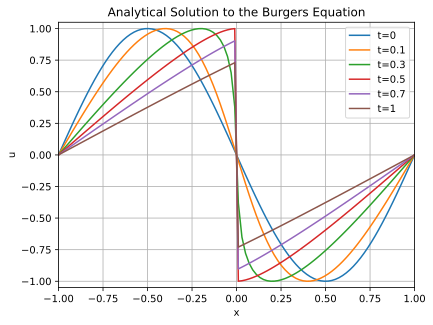

In [6]:
analytical_solutions = calculate_analytical_solutions()
plot_analytical_solutions(analytical_solutions, T_RANGE)

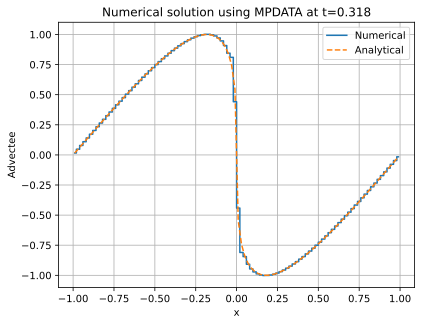

In [7]:
states_num, x_num, dt_num, dx_num = run_numerical_simulation(nt=NT, nx=NX, t_max=T_MAX)
plot_numerical_vs_analytical(states_num, x_num, T_SHOCK, T_MAX, NT)
plot_partial = partial(plot_gif, states=states_num, x=x_num, dt=dt_num)


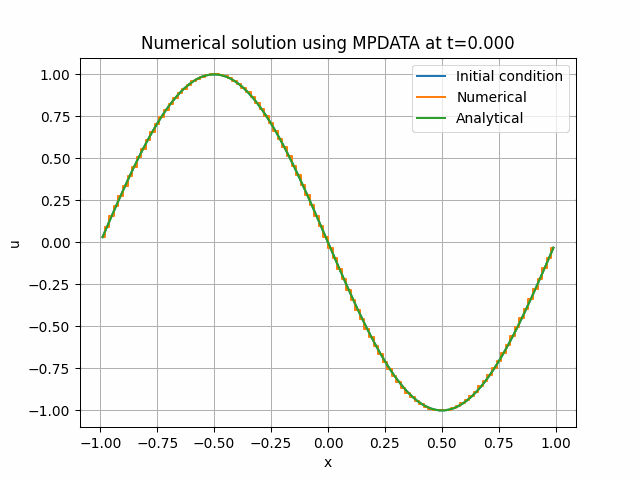

HTML(value="<a href='./numerical.gif' target='_blank'>./numerical.gif</a><br>")

In [8]:
show_anim(plot_partial, range(0, int(T_SHOCK/(T_MAX/NT)) - 10), gif_file="numerical.gif")